In [14]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import numpy as np

In [15]:
names_all = pd.read_csv('../annotations/fhr-annotations.tsv',sep='\t').PUBLIC_ID

In [16]:
names_all

0       MMRF_1014
1       MMRF_1017
2       MMRF_1024
3       MMRF_1038
4       MMRF_1033
          ...    
1138    MMRF_2846
1139    MMRF_2847
1140    MMRF_2848
1141    MMRF_2851
1142    MMRF_2853
Name: PUBLIC_ID, Length: 1143, dtype: object

In [17]:
ensgid = pd.read_csv('../annotations/ensgid-autosomal-proteincoding.txt', sep='\t', skiprows=1, names=['gid','gname','Chromosome','Start','End'])

In [18]:
# dfexp = pd.read_csv('/home/jiageng/Documents/fhr/data/Expression Estimates - Gene Based_MMRF_CoMMpass_IA22_salmon_geneUnstrandedIgFiltered_tpm.tsv.gz',sep='\t')

In [19]:
dfcn = pd.read_csv('/home/jiageng/Documents/fhr/data/Copy Number Estimates_MMRF_CoMMpass_IA22_genome_gatk_cna.seg',sep='\t').assign(PUBLIC_ID=lambda x: x['SAMPLE'].str.extract(r'(MMRF_\d{4})'))
dfcn = dfcn[~dfcn.Chromosome.isin(['chrX','chrY'])].assign(Chromosome=lambda x: x.Chromosome.str.extract(r'(\d+)').astype(int))

dfcn_1_samples = dfcn.sort_values('SAMPLE').groupby('PUBLIC_ID').head(1).SAMPLE.unique() # first sample
dfcn_1 = dfcn[dfcn.SAMPLE.isin(dfcn_1_samples)]

## Assign gene level copy number

First approach - too slow, do gene by gene

In [20]:
# initialize gene level copy number matrix
dfgcn = ensgid[['gid']].set_index('gid')
dfgcn = dfgcn.reindex(columns=dfgcn.columns.tolist() + dfcn_1_samples.tolist(), fill_value=pd.NA)

In [21]:
for idx,gene in ensgid.iterrows():
    # print(gene)
    dfchr = dfcn_1.loc[dfcn_1.Chromosome==f'chr{gene.Chromosome}']
    dfstart = dfchr.loc[dfchr['Start'] <= gene.Start]
    dfend = dfstart.loc[dfstart['End'] >= gene.End]
    if len(dfend)>0:
        dfgcn.loc[gene.gid, dfend.SAMPLE] = dfend['Segment_Mean'].values

KeyboardInterrupt: 

## Faster approach

Grid expand tables using chromosome as the key, then compare the start and end columns

In [22]:
ensgids_by_chr = [df[['gid','Chromosome','Start','End']] for _,df in ensgid.groupby('Chromosome')]

In [23]:
seg_by_chr = [df[['SAMPLE','Chromosome','Start','End','Segment_Mean']] for _, df in dfcn_1.groupby('Chromosome')]

In [24]:
# first pass - these are genes completely within a segment
df_gcn = pd.concat( [
    ensgids_by_chr[i]\
        .merge(seg_by_chr[i],on='Chromosome',suffixes=('_gene','_seg'))\
        .query('Start_seg <= Start_gene and End_gene <= End_seg')\
        .pivot(index=['gid'], columns='SAMPLE', values='Segment_Mean')
    for i in range(0,22)
    ])

missing_genes = ensgid[~ensgid['gid'].isin(df_gcn.index)]

# add the missing genes
df_gcn = pd.concat([df_gcn, pd.DataFrame(index=missing_genes['gid'])], axis=0).loc[ensgid.gid]

In [30]:
df_gcn.isna().sum()

MMRF_1016_1_BM_CD138pos     61
MMRF_1020_3_BM_CD138pos     53
MMRF_1021_1_BM_CD138pos     47
MMRF_1029_1_BM_CD138pos     39
MMRF_1030_1_BM_CD138pos     58
                          ... 
MMRF_2942_1_BM_CD138pos     44
MMRF_2943_1_BM_CD138pos     84
MMRF_2946_1_BM_CD138pos    114
MMRF_2947_1_BM_CD138pos     40
MMRF_2952_1_BM_CD138pos     66
Length: 924, dtype: int64

## Second pass - fill missing values

In [25]:
# second pass - these are genes spanning two segments in particular samples
# the value is NA after first pass
df_gcn_na = pd.concat( [
    ensgids_by_chr[i]\
        .merge(seg_by_chr[i],on='Chromosome',suffixes=('_gene','_seg'))\
        .query('(End_seg > Start_gene and End_seg < End_gene) or (End_gene > Start_seg and Start_gene < Start_seg)')
    for i in range(0,22)
    ])

In [21]:
sample='MMRF_1031_1_BM_CD138pos'
gid='ENSG00000285304'
ensgid.loc[gid==ensgid.gid]

,gid,gname,Chromosome,Start,End
12551,ENSG00000285304,NaN,22,37639693,37666932


In [26]:
df_gcn_na

,gid,Chromosome,Start_gene,End_gene,SAMPLE,Start_seg,End_seg,Segment_Mean
1935,ENSG00000142611,1,3069168,3438621,MMRF_1654_1_BM_CD138pos,799921,3076990,0.464857
1936,ENSG00000142611,1,3069168,3438621,MMRF_1654_1_BM_CD138pos,3076990,121605200,0.030217
3508,ENSG00000142611,1,3069168,3438621,MMRF_2152_1_BM_CD138pos,799921,3072000,0.621102
3509,ENSG00000142611,1,3069168,3438621,MMRF_2152_1_BM_CD138pos,3072000,66396000,0.054113
4170,ENSG00000142611,1,3069168,3438621,MMRF_2373_1_BM_CD138pos,799921,3370000,0.291415
...,...,...,...,...,...,...,...,...
1675107,ENSG00000128284,22,36139792,36166177,MMRF_2833_1_BM_CD138pos,36150000,47182500,-0.087017
1677681,ENSG00000128272,22,39519695,39522686,MMRF_2290_1_BM_CD138pos,34635412,39520882,0.039116
1677682,ENSG00000128272,22,39519695,39522686,MMRF_2290_1_BM_CD138pos,39520882,50782000,-0.966076
1678675,ENSG00000128272,22,39519695,39522686,MMRF_2723_1_BM_CD138pos,39370000,39520000,0.582275


In [27]:
# fill missing values
df_gcn_ann = df_gcn_na.assign(overlap = np.where((df_gcn_na.End_seg > df_gcn_na.Start_gene) & (df_gcn_na.End_seg < df_gcn_na.End_gene), df_gcn_na.Start_gene - df_gcn_na.End_seg + 1, np.where(((df_gcn_na.End_gene > df_gcn_na.Start_seg) & (df_gcn_na.Start_gene < df_gcn_na.Start_seg)), (df_gcn_na.End_gene - df_gcn_na.Start_seg + 1), np.where((df_gcn_na.Start_seg <= df_gcn_na.Start_gene) & (df_gcn_na.End_gene <= df_gcn_na.End_seg),(df_gcn_na.End_gene - df_gcn_na.Start_gene + 1),0))))

In [31]:
cn_na_values = df_gcn_ann.groupby(['gid','SAMPLE'])[['gid','SAMPLE','overlap','Segment_Mean']].apply(lambda x: x.sort_values('overlap', ascending=False).iloc[0]['Segment_Mean'])
cn_na_values

gid              SAMPLE                 
ENSG00000000419  MMRF_2144_1_BM_CD138pos    0.017286
ENSG00000000457  MMRF_1867_1_BM_CD138pos   -0.020544
ENSG00000001460  MMRF_2101_1_BM_CD138pos    0.020369
ENSG00000001617  MMRF_2839_1_BM_CD138pos    0.507817
                 MMRF_2905_1_BM_CD138pos    1.056202
                                              ...   
ENSG00000293642  MMRF_2422_1_BM_CD138pos    0.991825
ENSG00000300510  MMRF_2324_1_BM_CD138pos    0.347423
ENSG00000310517  MMRF_1426_1_BM_CD138pos    0.012793
                 MMRF_2167_1_BM_CD138pos    0.864381
                 MMRF_2429_1_BM_CD138pos    0.585453
Length: 24841, dtype: float64

In [140]:
cn_na_values.reset_index().gid.unique()

array(['ENSG00000000419', 'ENSG00000000457', 'ENSG00000001460', ...,
       'ENSG00000293642', 'ENSG00000300510', 'ENSG00000310517'],
      shape=(7244,), dtype=object)

In [29]:
df_gcn_ann.shape

(45540, 9)

In [33]:
missing_genes = ensgid[~ensgid['gid'].isin(df_gcn.index)]
df_gcn_full = pd.concat([df_gcn, pd.DataFrame(index=missing_genes['gid'])], axis=0)

In [34]:
df_gcn_maxoverlap = df_gcn_full.copy()

In [35]:
ensgid.shape

(18810, 5)

Add back missing values

In [36]:
for idx,row in pd.DataFrame(cn_na_values).iterrows():
    # dfgcn.loc[row.name[0], row.name[1]] = row
    # print(idx)
    # print(row[0])
    assert df_gcn_maxoverlap.loc[idx] != df_gcn_maxoverlap.loc[idx]
    df_gcn_maxoverlap.loc[idx] = row[0]

In [37]:
df_gcn_maxoverlap.isna().sum()

MMRF_1016_1_BM_CD138pos    23
MMRF_1020_3_BM_CD138pos    23
MMRF_1021_1_BM_CD138pos    23
MMRF_1029_1_BM_CD138pos    23
MMRF_1030_1_BM_CD138pos    23
                           ..
MMRF_2942_1_BM_CD138pos    23
MMRF_2943_1_BM_CD138pos    23
MMRF_2946_1_BM_CD138pos    23
MMRF_2947_1_BM_CD138pos    23
MMRF_2952_1_BM_CD138pos    23
Length: 924, dtype: int64

In [130]:
# these are 23 genes with no CN info completely
ensgid[ensgid.gid.isin(df_gcn_maxoverlap[df_gcn_maxoverlap.isna().sum(axis=1)>0].index)]

,gid,gname,Chromosome,Start,End
880,ENSG00000186092,OR4F5,1,65419,71585
1588,ENSG00000284733,OR4F29,1,450740,451678
1607,ENSG00000284662,OR4F16,1,685716,686654
2134,ENSG00000225899,FRG2B,10,133623895,133626795
3228,ENSG00000188076,SCGB1C1,11,193078,194575
5984,ENSG00000257115,OR11H12,14,18601117,18602097
6357,ENSG00000177693,OR4F4,15,101922042,101923113
8148,ENSG00000268320,SCGB1C2,17,137569,139067
9689,ENSG00000176695,OR4F17,19,107104,117102
9723,ENSG00000130726,TRIM28,19,58544064,58550722


In [62]:
dft = df_gcn_maxoverlap.loc[ensgid.gid].dropna().T.reset_index()
# dft = dft.assign(PUBLIC_ID=lambda x: x.index.str.extract(r'(MMRF_\d{4})'))
# dft.to_csv('gene_cn_matrix.tsv.gz', sep='\t')

In [72]:
dfout = dft.reset_index(drop=True).assign(PUBLIC_ID=lambda x: x.SAMPLE.str.extract(r'(MMRF_\d{4})')).set_index(['PUBLIC_ID','SAMPLE'])

In [73]:
dfout

,gid,ENSG00000142611,ENSG00000157911,ENSG00000142655,ENSG00000149527,ENSG00000171621,ENSG00000142583,ENSG00000173614,ENSG00000204624,ENSG00000142606,ENSG00000171729,ENSG00000157916,ENSG00000157881,ENSG00000048707,ENSG00000162444,ENSG00000180758,ENSG00000184677,ENSG00000131697,ENSG00000197921,ENSG00000204138,ENSG00000090020,ENSG00000158006,ENSG00000196581,ENSG00000169403,ENSG00000171612,ENSG00000188910,...,ENSG00000086062,ENSG00000127081,ENSG00000176978,ENSG00000165030,ENSG00000120235,ENSG00000236637,ENSG00000214042,ENSG00000186803,ENSG00000147885,ENSG00000198642,ENSG00000165092,ENSG00000135046,ENSG00000136936,ENSG00000178919,ENSG00000136932,ENSG00000136929,ENSG00000148057,ENSG00000135018,ENSG00000175787,ENSG00000175893,ENSG00000170777,ENSG00000147854,ENSG00000136877,ENSG00000165025,ENSG00000164978
PUBLIC_ID,SAMPLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MMRF_1016,MMRF_1016_1_BM_CD138pos,-0.007038,-0.007038,0.009244,-0.007038,-0.007038,-0.007038,0.009244,0.009244,-0.007038,0.009244,-0.007038,-0.007038,0.009244,0.009244,-0.007038,0.009244,-0.007038,-0.007038,0.009244,0.009244,0.009244,-0.007038,0.009244,-0.373055,0.009244,...,0.344063,0.554643,0.554643,0.554643,0.344063,0.344063,0.344063,0.344063,0.344063,0.344063,0.554643,0.554643,0.554643,0.554643,0.554643,0.554643,0.554643,0.554643,0.554643,0.344063,0.344063,0.344063,0.554643,0.554643,0.344063
MMRF_1020,MMRF_1020_3_BM_CD138pos,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,0.013751,...,0.579992,0.575844,0.574093,0.575844,0.579992,0.579992,0.579992,0.579992,0.579992,0.579992,0.575844,0.575844,0.575844,0.575844,0.575844,0.575844,0.575844,0.575844,0.575844,0.579992,0.579992,0.579992,0.574093,0.575844,0.579992
MMRF_1021,MMRF_1021_1_BM_CD138pos,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,0.349645,...,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.018429,0.014890,0.014890,0.018429,0.018429,0.018429
MMRF_1029,MMRF_1029_1_BM_CD138pos,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,0.018857,...,-0.274895,0.449222,0.449222,0.449222,-0.274895,-0.274895,-0.274895,-0.274895,-0.274895,-0.274895,0.449222,0.449222,0.449222,0.449222,0.449222,0.449222,0.449222,0.449222,0.449222,0.010012,0.011839,0.011839,0.449222,0.449222,-0.274895
MMRF_1030,MMRF_1030_1_BM_CD138pos,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,0.001882,...,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575154,0.575033,0.575033,0.575154,0.575154,0.575154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMRF_2942,MMRF_2942_1_BM_CD138pos,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,0.026399,...,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.007826,0.00713

: 

In [ ]:

dfout.to_csv('../matrices/gene_cn_matrix.tsv.gz', sep='\t')

## Segment mean to integers

not going to convert to integers for now

In [ ]:
visual method
segment mean [0.75, ____] = +2
segment mean [0.25, 0.75] = +1
segment mean [-0.5, 0.25] = 0
segment mean [-1.25,-0.5] = -1
segment mean [___, -1.25] = -2

<Axes: >

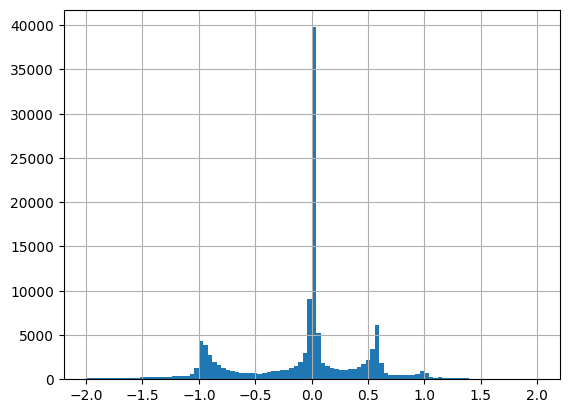

In [ ]:
dfcn.loc[(dfcn.Segment_Mean> -2) & (dfcn.Segment_Mean < 2)].Segment_Mean.hist(bins=100)